In [41]:
# run vectorize.py

In [130]:
import pickle as pkl
import numpy as np
import os
import sys
import subprocess as sp
from matplotlib import pyplot as plt
import imageio
import operator
from scipy.io import wavfile as wv
from scipy.fftpack import fft
from scipy import signal as sig

In [131]:
folder_list = ['data/video_1/', 'data/video_2/', 'data/video_3/', 'data/video_4/']
pkl_list = [i[:-1] + '_parsed.pkl' for i in folder_list]

In [132]:
# plt.figure()
# plt.imshow(frames[0])
# plt.show()

In [133]:
for i in pkl_list:
    video_src = open(i, 'rb')
    image_array = pkl.load(video_src)
    video_src.close()
    imageio.mimwrite('data/video_'+i.split('_')[1][0]+'.mp4', np.asarray(image_array) , fps = 30)


In [134]:
times = []
for i in pkl_list:
    video_file = 'data/video_'+i.split('_')[1][0]+'.mp4'
    print("Unpacking", video_file)
    scene_command = [
        'scenedetect',
        '--input',
        video_file,
        'detect-content',
        'list-scenes',
    ]
    os.system(' '.join(scene_command))
    # column 4 of csv 
    file = 'video_'+i.split('_')[1][0]+'-Scenes.csv'
    f = open(file, 'r')
    times.append(f.readlines()[0][15:].strip().split(','))
    f.close()
    
    

Unpacking data/video_1.mp4
Unpacking data/video_2.mp4
Unpacking data/video_3.mp4
Unpacking data/video_4.mp4


In [146]:
for i in times:
    for j in range(len(i)):
        tmp = i[j].split(':')
        sec = round(float(tmp[2])) + int(tmp[1])*60
        i[j] = sec



AttributeError: 'int' object has no attribute 'split'

/home/hensden/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


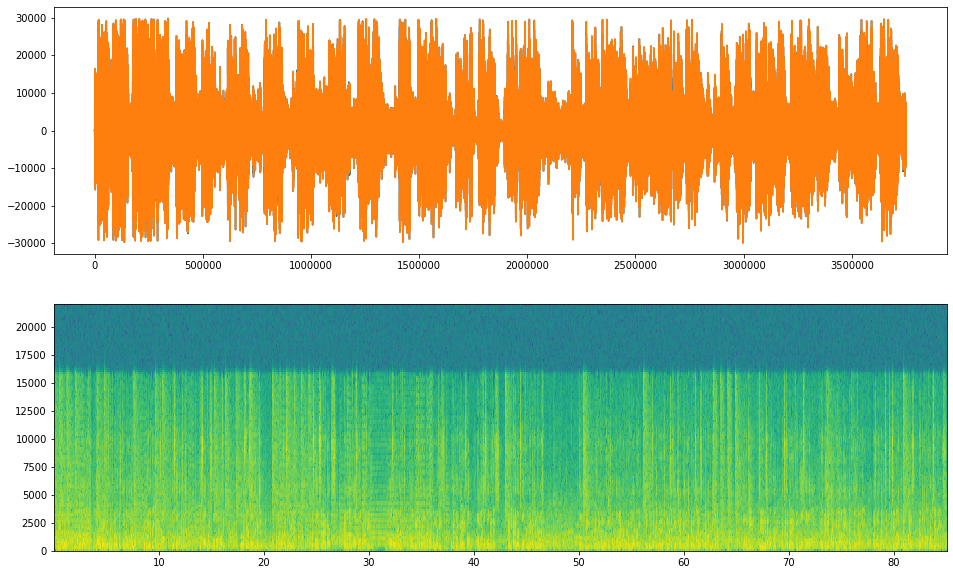

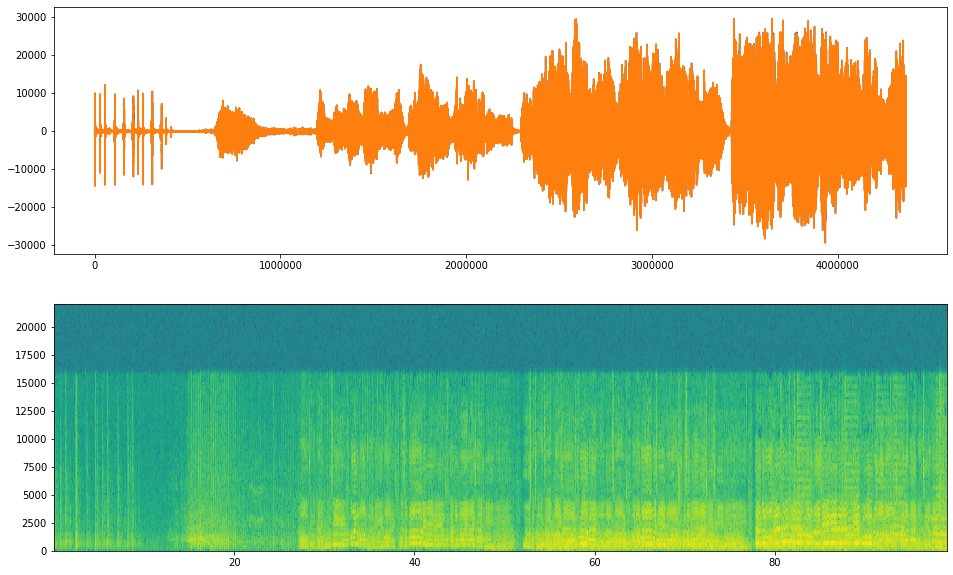

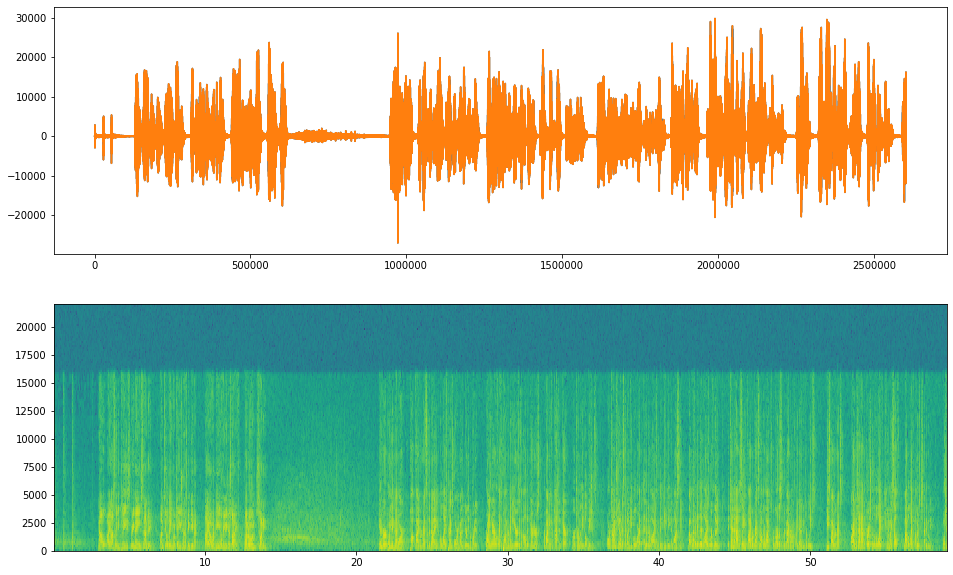

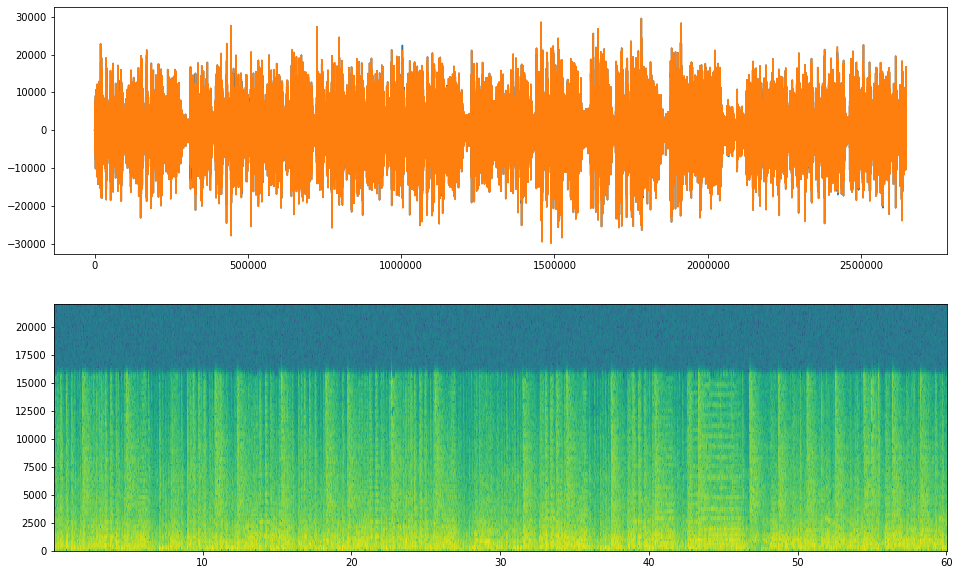

Each column denotes a chumk of 256 samples, that is around 5ms of data
(3750912, 2) (129, 29303) 85.05469387755102
(4368384, 2) (129, 34127) 99.05632653061224
(2603520, 2) (129, 20339) 59.03673469387755
(2647296, 2) (129, 20681) 60.02938775510204


In [136]:
waves = ['data/video_1.wav','data/video_2.wav','data/video_3.wav','data/video_4.wav']
data = [None, None, None, None]
for i, sample in enumerate(waves):
    tmp = {}
    tmp['fs'], tmp['data'] = wv.read(sample)
    data[i] = tmp
    
for signal in data:
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(signal['data'])
    plt.subplot(2,1,2)
    signal['psd'], freqs, time, img = plt.specgram(signal['data'][:,0], Fs=signal['fs'], NFFT=256)
    # peaks = sig.find_peaks(signal['data'][:,0])
    plt.show()
    
print("Each column denotes a chumk of 256 samples, that is around 5ms of data")
for i in range(4):
    print(data[i]['data'].shape, data[i]['psd'].shape, data[i]['data'][:,0].shape[0]/44100.0)

In [137]:
PS = []
for i in range(len(data)):
    columns = {}
    for j in range(data[i]['psd'].shape[1]):
        columns[j] = np.linalg.norm(data[i]['psd'][:,j])
    columns = dict(sorted(columns.items(), key=operator.itemgetter(1),reverse=True))
    PS.append(list(columns.items()))

In [148]:
audio_syn = [] 
for spectrum in PS:
    top_10 = []
    # +- 700 range
    for interval in spectrum:
        cf = False
        for j in top_10:
            if interval[0] >= j-1400 and interval[0] <= j+1400:
                cf = True
                break
        if cf is True:
            continue
        top_10.append(interval[0])
        if len(top_10) == 10:
            break
    for i in range(10):
        top_10[i] *= (128/44100.0)
        top_10[i] = round(top_10[i])
    audio_syn.append(top_10)
        
        

In [149]:
audio_syn

[[7, 21, 15, 41, 63, 2, 32, 28, 83, 68],
 [82, 66, 86, 59, 90, 71, 98, 54, 41, 75],
 [22, 30, 51, 46, 14, 37, 56, 41, 3, 8],
 [37, 12, 22, 31, 59, 7, 54, 18, 43, 1]]

In [147]:
times

[[2, 13, 20, 28, 33, 43, 46, 48, 60, 70, 71, 72, 75, 82],
 [4, 16],
 [3, 15, 20, 36, 51],
 [6, 17, 25, 47]]

In [187]:
# to write: code for nearest neighbour match

final_scenes = [[21, 42, 69, 81],
[4, 16, 41, 59, 66, 82],
[15, 28, 36, 51],
[6, 17, 24, 37, 45, 54 ]]
# intersections have to be there and then nearest neighbours
for i in range(4):
    final_scenes[i] += list(set(times[i]) & set(audio_syn[i]))
    final_scenes[i] = sorted(final_scenes[i])
# nearest neighbours next where frame not within 5 s of intersects

for i in final_scenes:
    for j in range(len(i)):
        i[j] *= 30
        


In [188]:
final_scenes

[[60, 630, 840, 1260, 2070, 2430],
 [120, 480, 1230, 1770, 1980, 2460],
 [90, 450, 840, 1080, 1530, 1530],
 [180, 510, 720, 1110, 1350, 1620]]

[ 2. 21. 28. 42. 69. 81.]


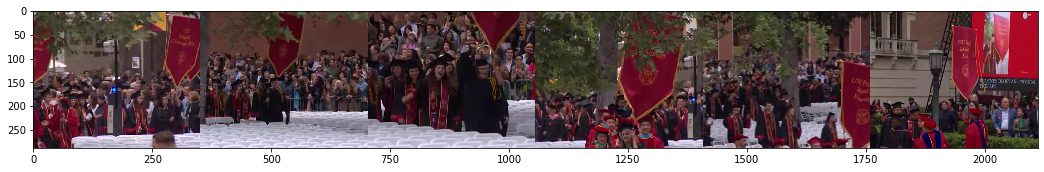

[ 4. 16. 41. 59. 66. 82.]


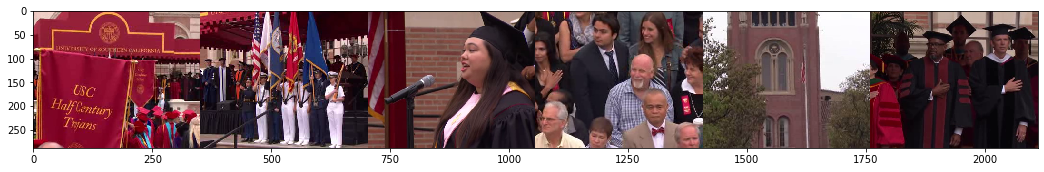

[ 3. 15. 28. 36. 51. 51.]


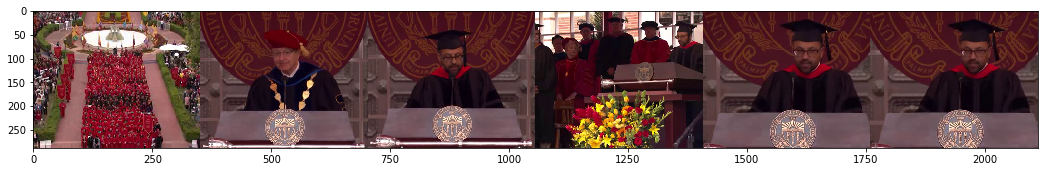

[ 6. 17. 24. 37. 45. 54.]


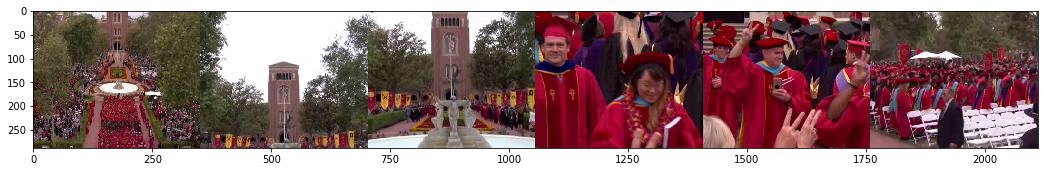

In [196]:
sup = []
for jk, i in enumerate(pkl_list):
    tup = []
    video_src = open(i, 'rb')
    image_array = pkl.load(video_src)
    video_src.close()
    for j in final_scenes[jk]:
        tup.append(image_array[j])
    IMG = np.hstack(tuple(tup))
    print(np.asarray(final_scenes[jk])/30)
    plt.figure(figsize=(18,4))
    sup.append(IMG)
    plt.imshow(IMG)
    plt.show()
    
# IMG2 = np.hstack(tuple(sup))
# plt.figure(figsize=(18,16))
# plt.imshow(IMG)
# plt.show()

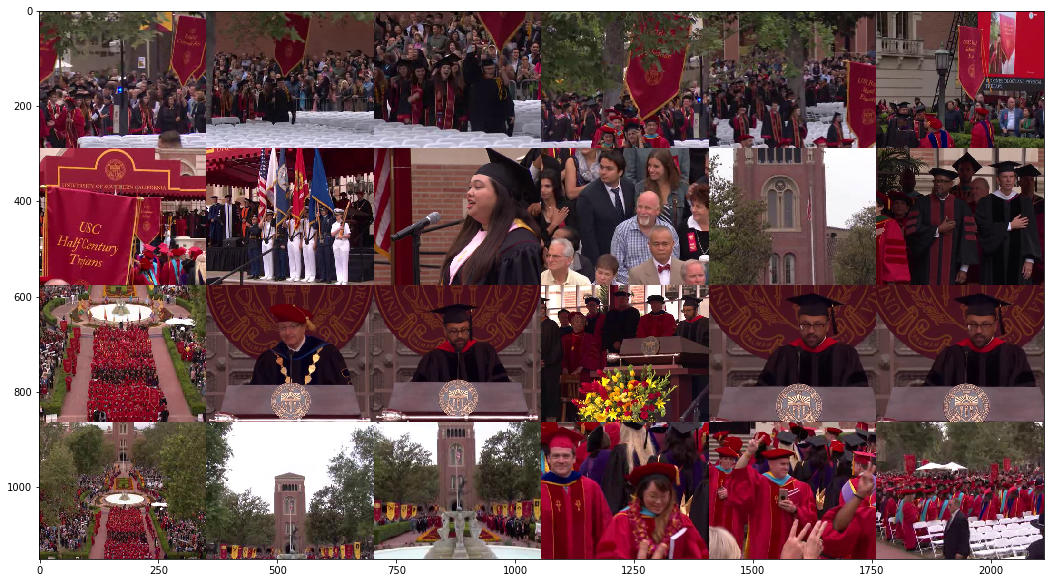

In [208]:
sup = np.asarray(sup)
IMG2 = np.uint8(np.zeros((1152, 2112, 3)))
for i in range(4):
    IMG2[i*288:(i+1)*288, :, :] = sup[i]
plt.figure(figsize=(18,16))
plt.imshow(IMG2)
plt.show()

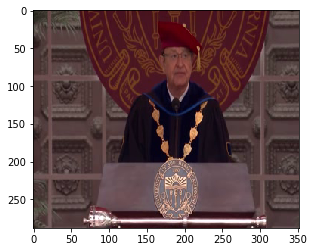

In [218]:

img_path = 'data/Image/RGB_parsed.pkl'
video_src = open(img_path, 'rb')
image_array = pkl.load(video_src)
video_src.close()


In [215]:
# KMEANS

100